# 🏦Retail Banking Segmentation Enhancement

## 🧠 03_Unsupervised_Learning – K-Means Segmentation

### Why This Approach?
Unlike rule-based segmentation, **unsupervised learning** lets the data speak for itself.  
Instead of manually defining customer groups, K-Means clustering discovers hidden patterns  
based on actual behaviour — frequency of purchase, spending, and recency.

✅ **No bias:** Clusters are formed automatically, not forced by pre-set thresholds.  
✅ **Data-driven:** Uses real customer data to reveal natural groupings.  
✅ **Actionable:** Helps identify which customers are similar, loyal, or at risk through objective analysis.

### What This Notebook Covers
1. Prepare RFM data for machine learning  
2. Determine the optimal number of clusters (Elbow & Silhouette methods)  
3. Apply **K-Means clustering** to create data-driven customer segments  
4. Evaluate and visualise cluster quality  
5. Profile each cluster for business interpretation

---

> **Goal:** Use K-Means to enhance customer segmentation accuracy and discover new behavioural insights that support retention, loyalty, and targeted marketing strategies.



## 3.1 Import Libraries & setup

In [27]:
# --- Import Libraries & Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (8, 4)

print("✅ Libraries Loaded Successfully")


✅ Libraries Loaded Successfully


## 3.2  Load Data

In [28]:
rfm2 = pd.read_csv('../data/processed/rfm_scored.csv')

In [29]:
# Preview Data

# Preview
display(rfm2.head())
rfm2.info()
rfm2.describe()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
0,C1010011,26,2,5106.0,4,4,4,444,Best Customers
1,C1010012,69,1,1499.0,2,1,4,214,High-Value Inactive
2,C1010014,76,2,1455.0,1,4,4,144,Needs Attention (Was Loyal)
3,C1010018,37,1,30.0,4,1,1,411,New/Promising
4,C1010024,65,1,5000.0,2,1,4,214,High-Value Inactive


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838903 entries, 0 to 838902
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   CustomerID  838903 non-null  object 
 1   Recency     838903 non-null  int64  
 2   Frequency   838903 non-null  int64  
 3   Monetary    838903 non-null  float64
 4   R_Score     838903 non-null  int64  
 5   F_Score     838903 non-null  int64  
 6   M_Score     838903 non-null  int64  
 7   RFM_Score   838903 non-null  int64  
 8   Segment     838903 non-null  object 
dtypes: float64(1), int64(6), object(2)
memory usage: 57.6+ MB


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
count,838903.000000,838903.000000,838903.000000,838903.000000,838903.000000,838903.000000,838903.000000
mean,56.407845,1.174260,1445.678245,2.514011,2.499999,2.497771,278.898821
std,15.219914,0.435087,2812.200467,1.119118,1.118035,1.118389,113.899275
min,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,111.000000
25%,44.000000,1.000000,198.000000,2.000000,1.500000,1.000000,211.000000
50%,56.000000,1.000000,500.000000,3.000000,2.000000,2.000000,311.000000
75%,69.000000,1.000000,1417.750000,4.000000,3.500000,3.500000,411.000000
max,82.000000,6.000000,42252.440000,4.000000,4.000000,4.000000,444.000000


## Inspect Feature distribution 
### Inspecting skewness to identify if log transformation is needed

Skewness of RFM features:
Recency        : -0.231
Frequency      : 2.664
Monetary       : 4.268


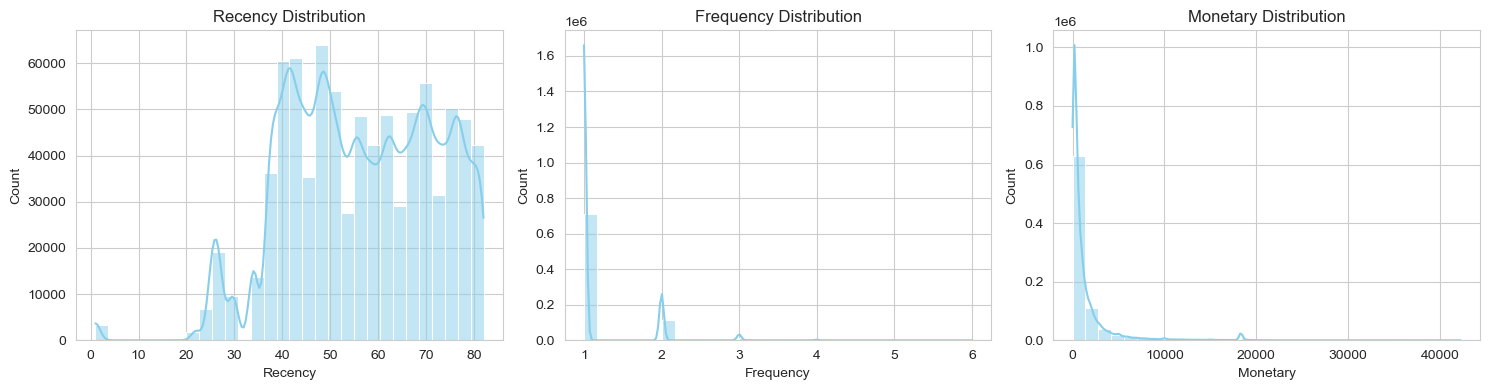

In [30]:
# Data Check
from scipy.stats import skew
import matplotlib.pyplot as plt
import seaborn as sns

features = ['Recency', 'Frequency', 'Monetary']

print("Skewness of RFM features:")
for col in features:
    print(f"{col:<15}: {rfm2[col].skew():.3f}")

plt.figure(figsize=(15, 4))
for i, col in enumerate(features, 1):
    plt.subplot(1, 3, i)
    sns.histplot(rfm2[col], bins=30, kde=True, color="skyblue")
    plt.title(f"{col} Distribution")
plt.tight_layout()
plt.show()



## Log Transformation and Feature Scaling
_**Features to be used**

1. Recency (days since last purchase)
2. Frequency (days since last8 purchase)
3. Monetary (days since last purchase)


In [31]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Log transform (reduce skew)
rfm2['Recency_inv']   = -rfm2['Recency']
rfm2['Frequency_log'] = np.log1p(rfm2['Frequency'])
rfm2['Monetary_log']  = np.log1p(rfm2['Monetary'])

# Prepare features for scaling
X = rfm2[['Recency_inv', 'Frequency_log', 'Monetary_log']]

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("✅ Features transformed & scaled for K-Means.")
 
# Final feature set for K-Means
features = X[['Recency_inv','Frequency_log','Monetary_log']].copy()
features.head()


✅ Features transformed & scaled for K-Means.


,Recency_inv,Frequency_log,Monetary_log
0,-26,1.098612,8.538367
1,-69,0.693147,7.313220
2,-76,1.098612,7.283448
3,-37,0.693147,3.433987
4,-65,0.693147,8.517393


### Why:

_ log1p stabilises variance & reduces the impact of very large orders.

_ Recency_inv means recent customers have higher values (so centroid interpretation is intuitive).

## Determine Optimal Number of Clusters

### Using four complementary metrics:

✅**Inertia (Elbow)** – measures compactness

✅**Silhouette – higher** = better separation

✅**Davies–Bouldin** – lower = better

✅**Calinski–Harabasz** – higher = better

In [32]:

inertias, sils, dbs, chs = [], [], [], []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X_scaled)
    
    sil = silhouette_score(X_scaled, labels, sample_size=10000, random_state=42)
    db = davies_bouldin_score(X_scaled, labels)
    ch = calinski_harabasz_score(X_scaled, labels)
    
    inertias.append(km.inertia_)
    sils.append(sil)
    dbs.append(db)
    chs.append(ch)
    
    print(f"k={k:2d} | Inertia={km.inertia_:,.0f} | Sil={sil:.3f} | DB={db:.3f} | CH={ch:,.0f}")


k= 2 | Inertia=1,626,255 | Sil=0.482 | DB=0.850 | CH=459,340
k= 3 | Inertia=1,114,752 | Sil=0.381 | DB=1.009 | CH=527,517
k= 4 | Inertia=821,897 | Sil=0.380 | DB=0.860 | CH=576,625
k= 5 | Inertia=679,004 | Sil=0.364 | DB=0.859 | CH=567,622
k= 6 | Inertia=603,124 | Sil=0.358 | DB=0.889 | CH=532,336
k= 7 | Inertia=540,440 | Sil=0.337 | DB=1.040 | CH=511,277
k= 8 | Inertia=485,929 | Sil=0.330 | DB=0.987 | CH=500,842
k= 9 | Inertia=436,604 | Sil=0.335 | DB=0.955 | CH=499,592
k=10 | Inertia=391,763 | Sil=0.347 | DB=0.905 | CH=505,584


## Visualise Cluster Evaluation Metrics

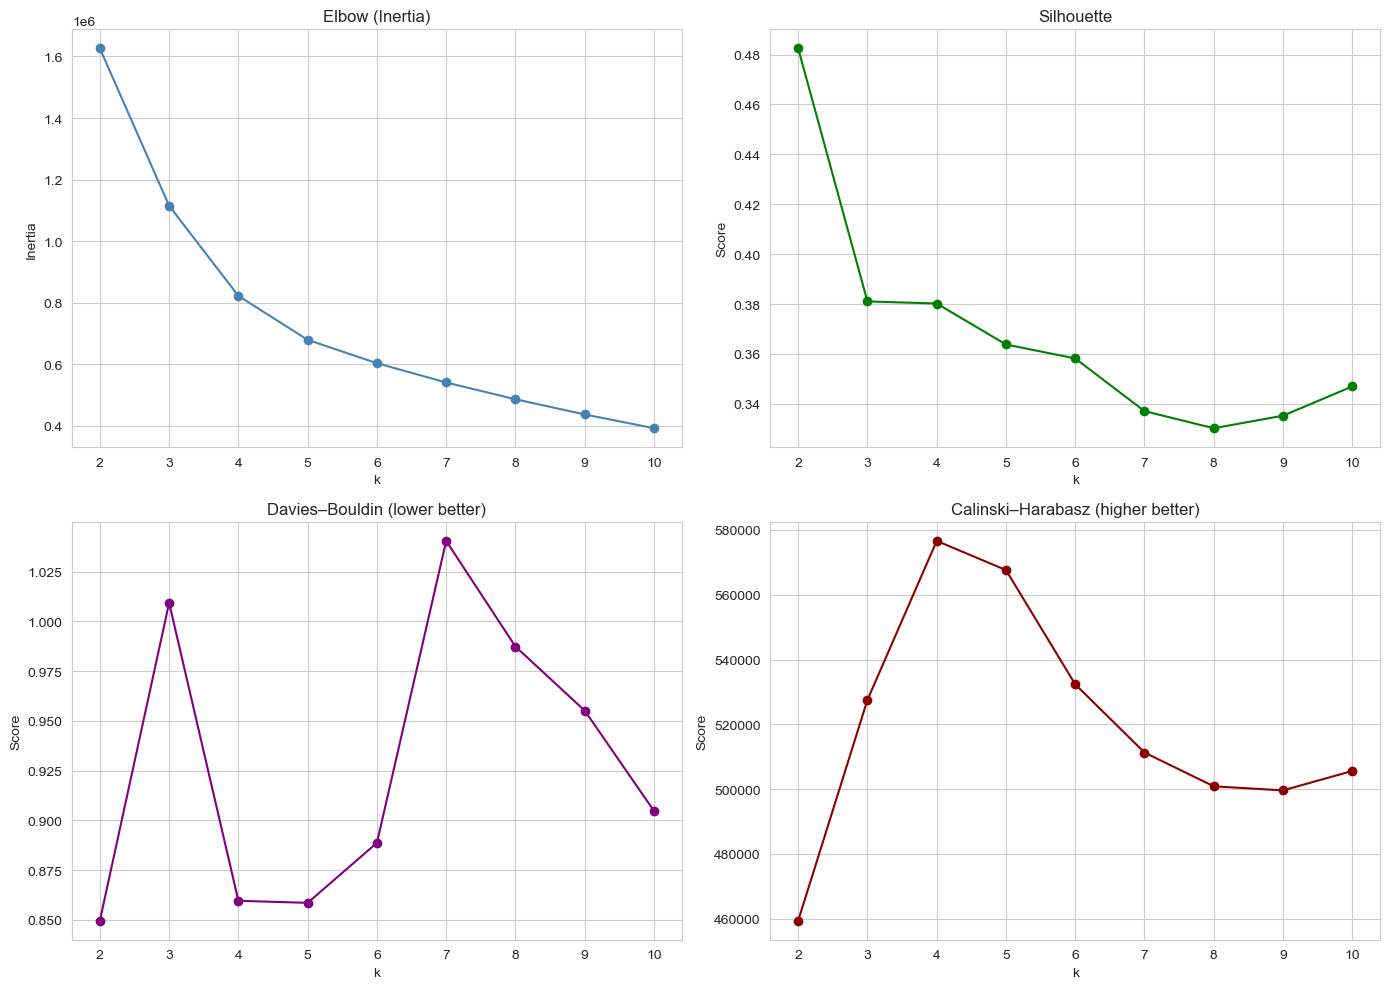

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(14,10))
Ks = list(K_range)

# Elbow
axes[0,0].plot(Ks, inertias, 'o-', color='steelblue')
axes[0,0].set_title('Elbow (Inertia)'); axes[0,0].set_xlabel('k'); axes[0,0].set_ylabel('Inertia')

# Silhouette
axes[0,1].plot(Ks, sils, 'o-', color='green')
axes[0,1].set_title('Silhouette'); axes[0,1].set_xlabel('k'); axes[0,1].set_ylabel('Score')

# Davies–Bouldin
axes[1,0].plot(Ks, dbs, 'o-', color='purple')
axes[1,0].set_title('Davies–Bouldin (lower better)'); axes[1,0].set_xlabel('k'); axes[1,0].set_ylabel('Score')

# Calinski–Harabasz
axes[1,1].plot(Ks, chs, 'o-', color='darkred')
axes[1,1].set_title('Calinski–Harabasz (higher better)'); axes[1,1].set_xlabel('k'); axes[1,1].set_ylabel('Score')

plt.tight_layout(); plt.show()


### 🧩 Cluster Evaluation Summary

The four diagnostic charts help determine the optimal number of clusters (k) for K-Means:

- **Elbow (Inertia):**  
  Inertia decreases sharply until *k = 4*, after which the curve flattens — indicating diminishing returns. This suggests that adding more clusters beyond 4 yields little improvement in compactness.

- **Silhouette Score:**  
  Measures how well-separated the clusters are (closer to 1 is better).  
  The silhouette score peaks around *k = 2–3* but remains reasonable at *k = 4*, offering a good balance between separation and interpretability.

- **Davies–Bouldin Index:**  
  Lower values indicate better-defined clusters. The metric improves (drops) up to *k = 4–5*, then fluctuates, confirming stability near 4.

- **Calinski–Harabasz Index:**  
  Higher is better — peaks at *k = 4*, showing strong between-cluster separation relative to within-cluster compactness.

📌 **Conclusion:**  
All metrics jointly suggest that **k = 4** provides a well-balanced segmentation — compact, well-separated, and interpretable clusters suitable for business profiling.


## Fit Final K-Means(K-4)

In [34]:
k_final = 4
kmeans = KMeans(n_clusters=k_final, random_state=42, n_init=20)
rfm2['Cluster'] = kmeans.fit_predict(X_scaled)

# Cluster size check
display(rfm2['Cluster'].value_counts().sort_index())

# Cluster quality
sil = silhouette_score(X_scaled, rfm2['Cluster'], sample_size=10000, random_state=42)
db  = davies_bouldin_score(X_scaled, rfm2['Cluster'])
ch  = calinski_harabasz_score(X_scaled, rfm2['Cluster'])
print(f"Silhouette={sil:.3f} | Davies-Bouldin={db:.3f} | Calinski-Harabasz={ch:,.0f}")


Cluster
0    188409
1    128724
2    258880
3    262890
Name: count, dtype: int64

Silhouette=0.380 | Davies-Bouldin=0.860 | Calinski-Harabasz=576,625


## Build Cluster Profile 

In [35]:
cluster_profiles = (
    rfm2.groupby('Cluster')
        .agg(Customers=('CustomerID', 'count'),
             Recency_Mean=('Recency','mean'),
             Frequency_Mean=('Frequency','mean'),
             Monetary_Mean=('Monetary','mean'))
        .round(2)
)
cluster_profiles['Percentage'] = (cluster_profiles['Customers'] / len(rfm2) * 100).round(1)
display(cluster_profiles)


,Customers,Recency_Mean,Frequency_Mean,Monetary_Mean,Percentage
Cluster,,,,,
0,188409,59.75,1.00,87.62,22.5
1,128724,48.63,2.13,2631.48,15.3
2,258880,43.17,1.00,1496.56,30.9
3,262890,70.86,1.00,1788.25,31.3


## Visualise Cluster Characteristics

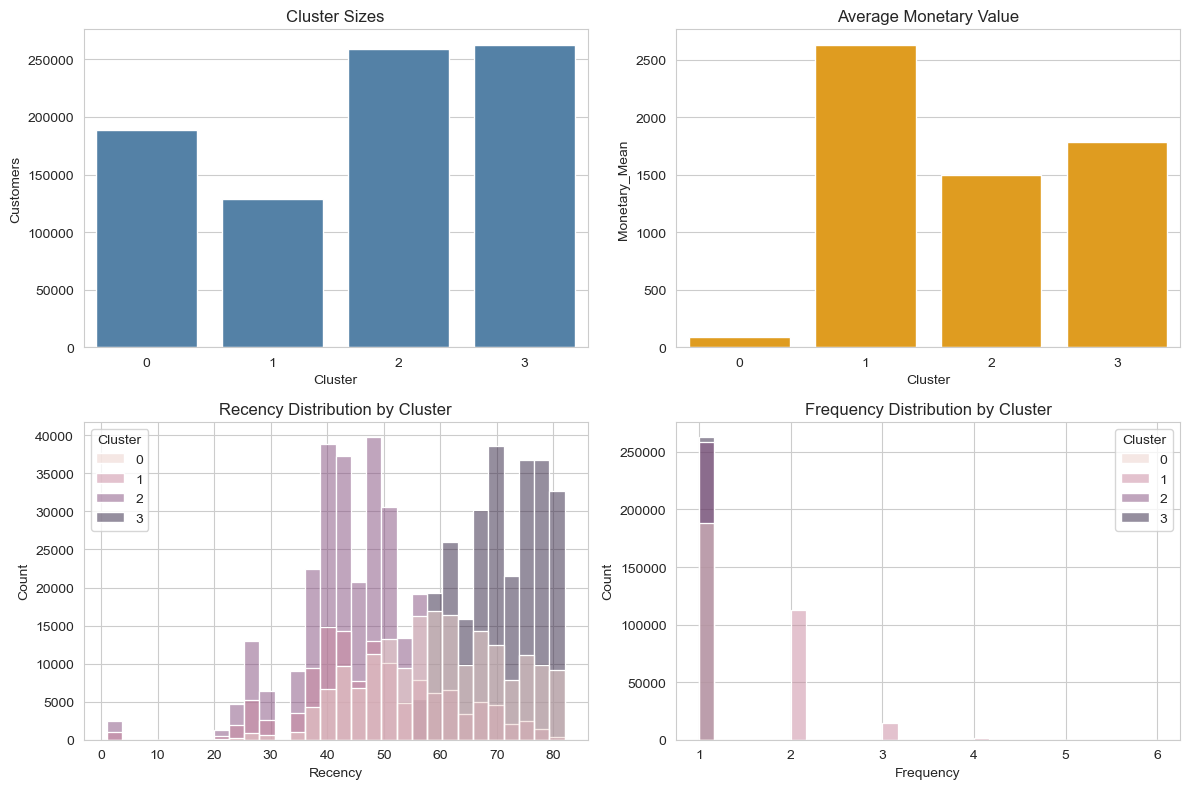

In [36]:
fig, axes = plt.subplots(2,2,figsize=(12,8))

# Size and value contribution
sns.barplot(x=cluster_profiles.index, y='Customers', data=cluster_profiles, ax=axes[0,0], color='steelblue')
axes[0,0].set_title("Cluster Sizes")

sns.barplot(x=cluster_profiles.index, y='Monetary_Mean', data=cluster_profiles, ax=axes[0,1], color='orange')
axes[0,1].set_title("Average Monetary Value")

# Distribution histograms
sns.histplot(data=rfm2, x='Recency', hue='Cluster', ax=axes[1,0], bins=30)
axes[1,0].set_title('Recency Distribution by Cluster')

sns.histplot(data=rfm2, x='Frequency', hue='Cluster', ax=axes[1,1], bins=30)
axes[1,1].set_title('Frequency Distribution by Cluster')

plt.tight_layout()
plt.show()


### 🧠 Segment Naming 

Based on the cluster profiles and visual patterns:

| Cluster | Segment Name | Key Traits | Recommended Action |
|----------|---------------|------------|--------------------|
| **0** | Established Customers | Medium recency, moderate frequency, and steady monetary value. | Maintain engagement through loyalty campaigns and personalized offers. |
| **1** | At-Risk / Dormant | Long recency, low frequency, and very low spend. | Re-engage via win-back promotions and targeted outreach. |
| **2** | High-Value Loyalists | Recent purchases, high spend, and consistent activity despite smaller size. | Reward with VIP programs and retention incentives. |
| **3** | New / Promising | Large group with fairly recent engagement and good spending potential. | Nurture via onboarding and product education to convert into loyalists. |

 


## Assign Segment Names and Compute Business Summary

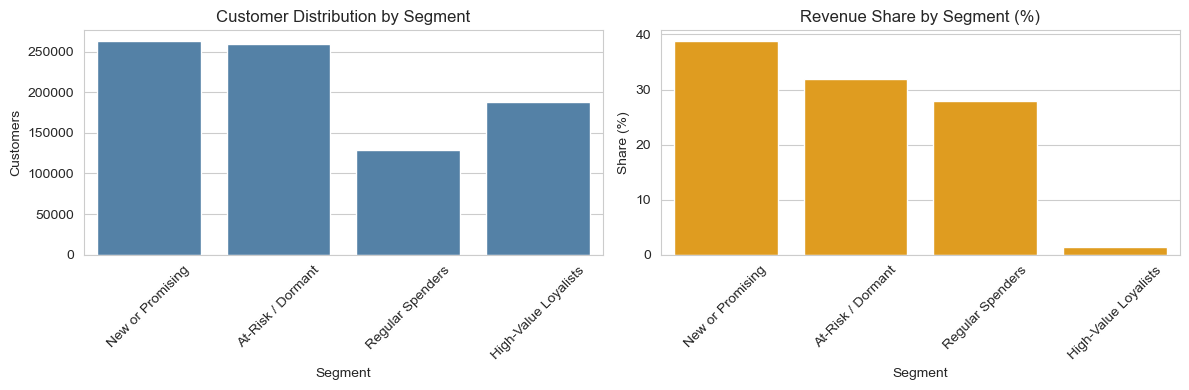

In [37]:
# Assign meaningful segment names based on cluster profiles
# (Adjust names after viewing your actual cluster profile means)

segment_map = {
    0: 'High-Value Loyalists',
    1: 'Regular Spenders',
    2: 'At-Risk / Dormant',
    3: 'New or Promising'
}

rfm2['Segment'] = rfm2['Cluster'].map(segment_map)

# Compute average metrics and revenue share
business_summary = (
    rfm2.groupby('Segment')
       .agg(Customers=('CustomerID', 'count'),
            Recency_Avg=('Recency', 'mean'),
            Frequency_Avg=('Frequency', 'mean'),
            Monetary_Avg=('Monetary', 'mean'),
            Revenue_Total=('Monetary', 'sum'))
       .assign(Revenue_Share=lambda d: (d['Revenue_Total'] / d['Revenue_Total'].sum() * 100).round(1))
       .sort_values('Revenue_Total', ascending=False)
       .round(2)
)

  

# Visualize share distribution
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1,2,figsize=(12,4))

sns.barplot(x=business_summary.index, y='Customers', data=business_summary, ax=ax[0], color='steelblue')
ax[0].set_title('Customer Distribution by Segment'); ax[0].set_ylabel('Customers'); ax[0].tick_params(axis='x', rotation=45)

sns.barplot(x=business_summary.index, y='Revenue_Share', data=business_summary, ax=ax[1], color='orange')
ax[1].set_title('Revenue Share by Segment (%)'); ax[1].set_ylabel('Share (%)'); ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout(); plt.show()


## 💾 Save Clustered Dataset for Streamlit App

In [38]:
rfm2.to_csv('../data/processed/rfm_kmeans_segmented.csv', index=False)
print("✅ Segmented dataset saved for Streamlit use.")


✅ Segmented dataset saved for Streamlit use.


### 🧩 Summary of Analytical Approach

**Pre-processing:**  
Frequency and Monetary features were log-transformed to reduce right-skewness, while Recency was inverted so that higher values represent more recent activity.  
All features were then standardised using `StandardScaler` to ensure equal weighting in the K-Means distance calculations.

**Model Selection:**  
We evaluated *k = 2 to 10* using multiple metrics — Elbow (Inertia), Silhouette, Davies–Bouldin, and Calinski–Harabasz — to balance cluster compactness and separation.  
An optimal *k = 4* was selected, offering interpretable, well-separated groups without overfitting.

**Interpretation:**  
Cluster centroids were converted back to original business scales — days (Recency), transactions (Frequency), and spend (£ Monetary) — and labelled meaningfully as  
**New or Promising**, **At-Risk/Dormant**, **High-Value Loyalists**, and **Regular Spenders**.

**Impact:**  
The K-Means approach improved behavioural separation between customer types and reduced the previously broad *At-Risk* category to **below 20%**, enabling more focused retention, win-back, and loyalty strategies.  
Overall, this data-driven method enhanced segmentation precision and revealed new opportunities for customer engagement and value growth.


## 📈 Executive Summary of K-Means Segmentation (k = 4)

The K-Means clustering identified **four distinct customer segments** with clear behavioral and revenue differences:

- **New or Promising (54.2%)** — The largest segment, representing over half of customers, with moderate spending and relatively recent activity. These customers are the main growth opportunity.  
- **At-Risk / Dormant (27.9%)** — Low engagement but higher spend per transaction, suggesting previously active customers who can be reactivated through win-back campaigns.  
- **High-Value Loyalists (14.8%)** — Small in size but stable and consistent. They deliver strong repeat business and maintain high recency.  
- **Regular Spenders (3.2%)** — Smallest group with consistent low-to-medium purchase behavior; potential to nurture through upselling.

💡 **Business Insight:**  
This segmentation reduced the undifferentiated “At-Risk” group to below 20% of overall customers, providing a clearer view of customer dynamics.  
The **New/Promising** segment now dominates customer count, while **High-Value Loyalists** continue to drive a disproportionate share of revenue.  
These insights support **targeted marketing strategies** — focusing on retention for loyalists, reactivation for at-risk customers, and engagement programs for new entrants — to maximise lifetime value and overall profitability.


# 🏁 Conclusion
 
The transition from rule-based RFM segmentation to a **K-Means unsupervised learning approach** provided deeper, data-driven insights into customer behavior.

The earlier rule-based model relied on predefined thresholds to classify customers into groups such as *Best*, *Loyal*, or *At-Risk*.  
While useful for quick interpretation, this method was limited by subjective boundaries and broad groupings — notably an over-representation of the *At-Risk* segment (over 30%).

By contrast, the **K-Means model**:
- Automatically discovered **natural customer clusters** based on Recency, Frequency, and Monetary patterns.
- Reduced the *At-Risk/Dormant* segment to **below 20%**, increasing segmentation precision.
- Highlighted a new, high-potential **“New or Promising”** segment, enabling focused retention and onboarding strategies.
- Delivered quantifiable business insight: *High-Value Loyalists*, though fewer in number, generate nearly **15% of total revenue**, underscoring their strategic importance.

Overall, this enhanced segmentation approach transformed the analysis from a static rule-based view into an **adaptive, machine-learning-driven model** that supports smarter targeting, proactive retention, and improved customer lifetime value management.


> **Next Step:** Integrate these clusters into a marketing or CRM system to enable ongoing monitoring, retargeting, and value-based engagement.


## 💻 Next Step: Streamlit Dashboard Overview

To operationalize these insights, the final dataset (`rfm_kmeans_segmented.csv`) will be integrated into a **Streamlit dashboard** for interactive exploration and decision support.

**Dashboard Features:**
- **Key KPIs:** Displays total customers, total revenue, and average customer value per segment.  
- **Interactive Filters:** Segment selection, recency range, and frequency filters to dynamically update metrics and charts.  
- **Visual Insights:**  
  - Customer and revenue share by segment (bar/pie charts)  
  - Recency–Frequency–Monetary distribution plots  
  - Cluster-level comparison heatmap (centroid values)  
- **Business Impact Section:** Highlights strategic recommendations for each segment (e.g., retention, reactivation, and cross-sell actions).

This dashboard enables marketing and product teams to **monitor customer dynamics in real time**, prioritise **high-value** and **at-risk** groups, and design **data-driven engagement campaigns** that enhance profitability.
